In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib as jb
import os
from typing import List, Dict, Union, Optional, Tuple
import seaborn as sns

%matplotlib inline
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-dark')

# declare paths to data
TRAIN_PATH = 'data/train'
VALID_PATH = 'data/validation'
TEST_PATH = 'data/test'
CHECKPOINT = 'checkpoints/weights.hdf5'
HISTORY_PATH = 'checkpoints/train_history.pkl'
MODEL_NAME = 'LinnaeusBotClassifier'
CLASSES = ['damselflies', 'dragonflies']

In [179]:
x = {}
x[TRAIN_PATH] = {}
x[TRAIN_PATH][CLASSES[0]] = 2

In [295]:
def annotate(axes:Union[np.ndarray, plt.Axes]):
    '''
    annotate a singular ax or a matrix of subplots ax
    inputs: 
        axes: singular matplotlib.pyplot ax or a matrix or ax
    '''
    def _annotate(ax: plt.Axes):
        for p in ax.patches:

            # establish text position
            _horizontal_position = p.get_x() + p.get_width() / 2
            _vertical_position = p.get_y() + p.get_height() / 2

            # define the value to add to the graph
            value = f'{int(p.get_height())}' 

            # add text
            ax.text(_horizontal_position, _vertical_position, value,  ha="center", fontsize=16) 
            pass
    
    if isinstance(axes, np.ndarray):
        for _, ax in np.ndenumerate(axes):
            _annotate(ax)
    else:
        _annotate(axes)
    pass

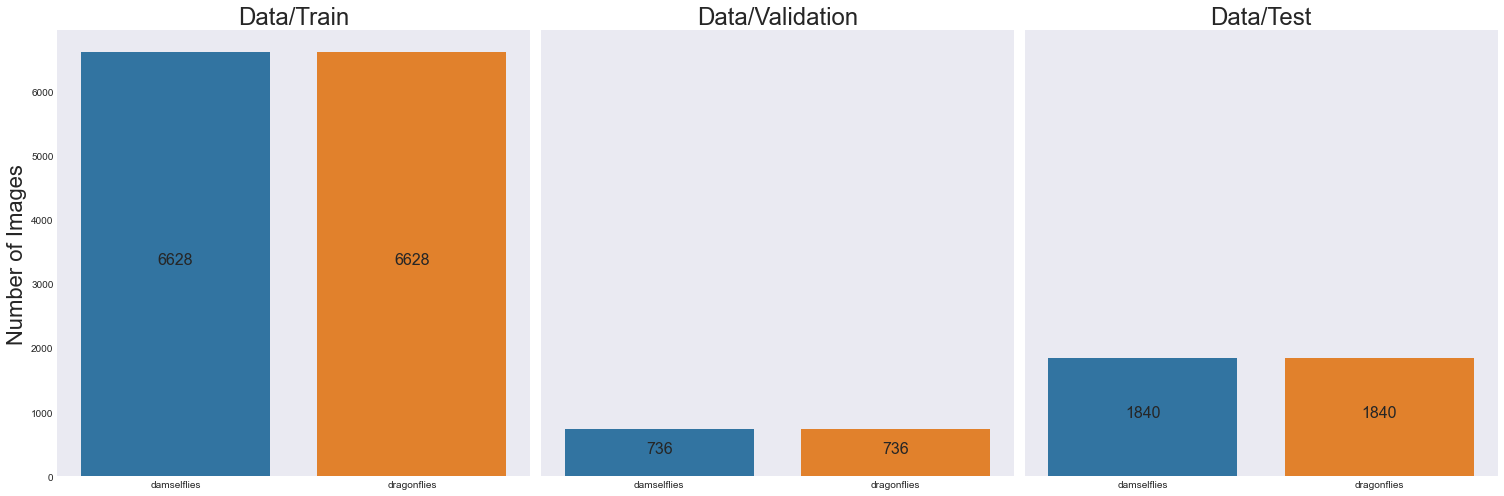

In [297]:
ALL_PATHS = [TRAIN_PATH, VALID_PATH, TEST_PATH]
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

folder_dict = {}
for i, folder in enumerate(ALL_PATHS):        
        folder_dict[folder] = {}
        
        # count the number of images within each class within every folder
        for subfolder in CLASSES:
            subfolder_path = os.path.join(folder, subfolder)
            
            # count the number of files in the subfolder
            folder_dict[folder][subfolder] = len(os.listdir(subfolder_path))  
        
        # count the numer of images in each subfolder within the dataset folders
        x = list(folder_dict[folder].keys())
        y = list(folder_dict[folder].values()) 
        sns.barplot(x=x, y=y, ax=axes[i])
        axes[i].set_title(folder.title(), size=24)
        
        if i == 0:
            axes[i].set_ylabel("Number of Images", size=22)
        
annotate(axes)          
plt.tight_layout()

## Image Augmentation Pipeline

* #### Training Data

    1. Shuffle
    1. Resize image
    1. Grayscale image
    1. Noramalize pixel values
    1. Horizontal image flip
    1. Vertical image flip
    1. Rotate image
    1. Adjusted image brightness
       
    
* #### Validation & Testing data

    1. Noramalize pixel values
    2. Grayscale images
    
    
Note, there's a minor class imbalance in favor of dragonflies. \
Since it's not that large I will not try to adjust it.

In [4]:
# declare image augmentation related hyperparameters
TARGET_SIZE = (256, 256)
RESCALE = 1.0 / 255
COLOR_MODE = 'grayscale'
BATCH_SIZE = 16
ROTATION = 25
BRIGHTNESS = [0.4, 1.0]

# declare flow related hyper parameters 
EPOCHS = 40
CLASS_MODE = 'categorical'
CHECKPOINT = "checkpoints/weights.hdf5"

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# randomly flip, and rotate images, adjust brightish, and normalize pixel values
trainGenerator = ImageDataGenerator(rescale=RESCALE, 
                                    horizontal_flip=True,  
                                    vertical_flip=True,
                                    rotation_range=ROTATION,
                                    brightness_range=BRIGHTNESS)  

# only scale the pixel values validation images
validatioinGenerator = ImageDataGenerator(rescale=RESCALE)

# only scale the pixel values test images
testGenerator = ImageDataGenerator(rescale=RESCALE)

# instanciate train flow
trainFlow = trainGenerator.flow_from_directory(
    TRAIN_PATH,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = COLOR_MODE,
    class_mode = CLASS_MODE,
    shuffle=True
) 

# instanciate validation flow
validationFlow = validatioinGenerator.flow_from_directory(
    VALID_PATH,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = COLOR_MODE,
    class_mode= CLASS_MODE,
    shuffle=False
)

## Define Model Architecture
# I tried to create a light-weight version of the VGG16.
# Instead of two convolution layers before MaxPooling, 
# I limited it to one Convolution layer
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256 , 256, 1)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu' ),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(.3),
    Dense(64, activation='relu'),
    Dropout(.3),
    Dense(2, activation='softmax')
])

# trial and error, lowering learning rate gets better results
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

# create model checkpoint in case of overfitting
checkpoints = ModelCheckpoint(CHECKPOINT, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# train model
history = model.fit(
    trainFlow,
    validation_data=validationFlow, 
    callbacks=[checkpoints],
    epochs=EPOCHS
)

model.save(MODEL_NAME)
jb.dump(history, HISTORY_PATH)

Using TensorFlow backend.


Found 12728 images belonging to 2 classes.
Found 1406 images belonging to 2 classes.
Epoch 1/40
796/796 [==============================] - 242s 304ms/step - loss: 0.6077 - accuracy: 0.6552 - val_loss: 0.1797 - val_accuracy: 0.7219

Epoch 00001: val_accuracy improved from -inf to 0.72191, saving model to checkpoints/weights.hdf5
Epoch 2/40
  2/796 [..............................] - ETA: 48s - loss: 0.6186 - accuracy: 0.5625

C:\Users\GILOR\Anaconda3\envs\py36\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


796/796 [==============================] - 236s 297ms/step - loss: 0.4774 - accuracy: 0.7681 - val_loss: 0.2380 - val_accuracy: 0.8172

Epoch 00002: val_accuracy improved from 0.72191 to 0.81721, saving model to checkpoints/weights.hdf5
Epoch 3/40
796/796 [==============================] - 234s 294ms/step - loss: 0.4196 - accuracy: 0.8006 - val_loss: 0.5695 - val_accuracy: 0.8250

Epoch 00003: val_accuracy improved from 0.81721 to 0.82504, saving model to checkpoints/weights.hdf5
Epoch 4/40
796/796 [==============================] - 230s 289ms/step - loss: 0.3923 - accuracy: 0.8147 - val_loss: 0.8364 - val_accuracy: 0.8300

Epoch 00004: val_accuracy improved from 0.82504 to 0.83001, saving model to checkpoints/weights.hdf5
Epoch 5/40
796/796 [==============================] - 235s 295ms/step - loss: 0.3710 - accuracy: 0.8285 - val_loss: 0.1596 - val_accuracy: 0.8634

Epoch 00005: val_accuracy improved from 0.83001 to 0.86344, saving model to checkpoints/weights.hdf5
Epoch 6/40
796/796 


Epoch 00039: val_accuracy did not improve from 0.92532
Epoch 40/40
796/796 [==============================] - 228s 287ms/step - loss: 0.1884 - accuracy: 0.9175 - val_loss: 0.0719 - val_accuracy: 0.9182

Epoch 00040: val_accuracy did not improve from 0.92532


['checkpoints/train_history.pkl']

## Model Evaluation

In [6]:
try:
    del model
except Exception as e:
    print(str(e))

model = load_model(MODEL_NAME)
model.load_weights(CHECKPOINT)
history = jb.load(HISTORY_PATH)

# only scale the pixel values test images
testGenerator = ImageDataGenerator(rescale=RESCALE)

testFlow = testGenerator.flow_from_directory(
    TEST_PATH,
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = COLOR_MODE,
    class_mode= CLASS_MODE,
    shuffle = False 
)

# custom tensorflow optimizer with keras model requires compiling the model again
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

loss, acc = model.evaluate(testFlow)
print(f'Test accuracy" {acc}')
print(f'Test loss" {loss}')

C:\Users\GILOR\Anaconda3\envs\py36\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Found 3532 images belonging to 2 classes.
221/221 [==============================] - 41s 185ms/step
Test accuracy" 0.9125141501426697
Test loss" 0.40273645520210266


In [7]:
# Show the images and predictions 
predict = model.predict(testFlow)
predictions = predict.argmax(1)
labels = testFlow.labels

In [57]:
def plot_intermediate_activation(model, images, bottom=0, top=3, save=False):
    '''
    This function plots the intermidiate interpartation of an image
    plot_intermediate_activation(model, images, bottom=0, top=3, save=False):
    Inputs:
        model: Compiled keras model object
        images: Numpy array containing image you want to disply
        bottom: Which layer to begin showing
        top: Which layer to stop showing
        save: Optional, saving as .png image object. default=False
    Returns:
         Images displaying what each convolution layer detects        
    '''
   
    # images = np.expand_dims(images, axis=0)

    # extract layer's outputs
    layer_outputs = [layer.output for layer in model.layers[bottom:top]]

    # Creates keras Model
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(images)
    layer_names = [layer.name for layer in model.layers[bottom:top]]

    # Define how the amount of images per row
    images_per_row = 8

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]  # number of features
        size = layer_activation.shape[1]  # feature map
        n_cols = n_features // images_per_row  # tiles the activation channels
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):  # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                # post-processes the features to visualize the activation layers
                channel_image = layer_activation[0, :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image
        
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1] * 4,
                            scale * display_grid.shape[0] * 4))
        plt.title(layer_name)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        if save:
            plt.savefig(f'activation_{save}_vis.jpg')
            save += 1
    return

In [333]:
# plot a batch of images from the testset
images, labels = next(iter(testFlow))

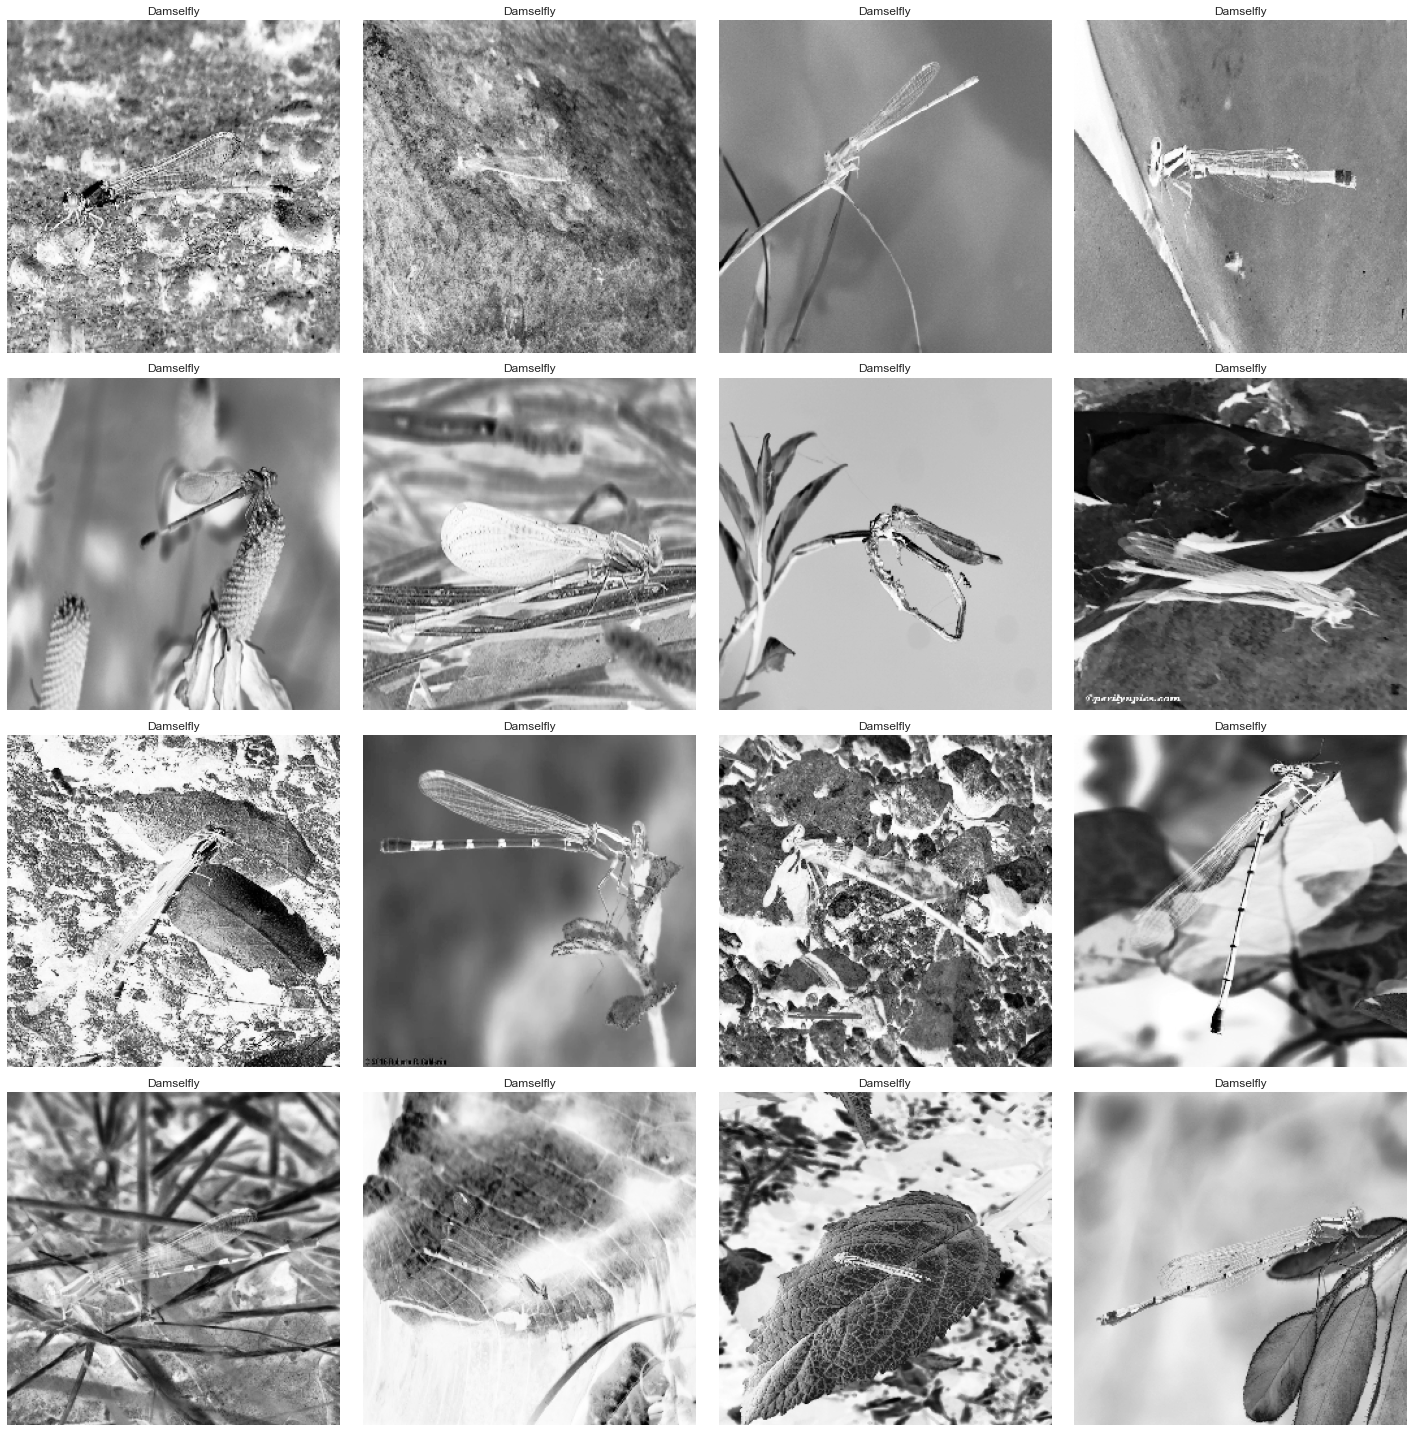

In [334]:
# display the images (the flow is not shuffled)
fig, axes = plt.subplots(4, int(BATCH_SIZE/4), figsize=(20, 20))

for i, ax in enumerate(axes.ravel()):
    label = 'Damselfly' if (labels[i] == [1, 0]).all() else 'Dragonfly'
    image = np.squeeze(images[i])
    ax.imshow(image)
    ax.set_axis_off()
    ax.set_title(f'{label}')

plt.tight_layout()

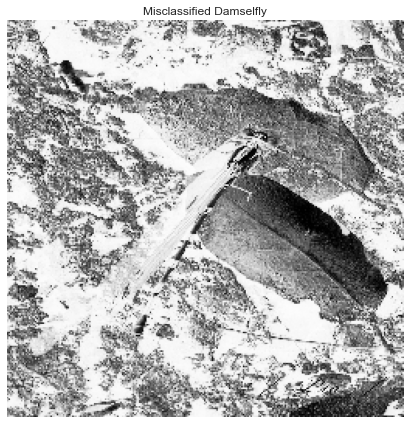

In [344]:
# find the misclassified ones
misclassified_indice = []
for i, image in enumerate(images):
    
    # expand dims
    image = np.expand_dims(image, axis=0)
    
    # predict
    preds = model.predict(image)
    pred = preds.argmax(1)
    label = labels[i].argmax(0)
    
    # identify where the model was wrong
    if label != pred:
        misclassified_indice.append(i)

# show the misclasified images
misclassified = len(misclassified_indice)       
fig, axes = plt.subplots(1, misclassified, figsize=(6 * misclassified, 6 * misclassified))

if misclassified:
    if isinstance(axes, np.ndarray):
        for i, ax in enumerate(axes): 
            
            miss = misclassified_indice[i]
            label = 'Damselfly' if (labels[miss] == [1, 0]).all() else 'Dragonfly' 
            image = np.squeeze(images[miss])
            
            ax.imshow(image)
            ax.set_axis_off()
            ax.set_title(f'Misclassified {label}')

    else:
        miss = misclassified_indice[0]
        label = 'Damselfly' if (labels[miss] == [1, 0]).all() else 'Dragonfly' 
        image = np.squeeze(images[miss])
        
        axes.imshow(image)
        axes.set_axis_off()
        axes.set_title(f'Misclassified {label}')
plt.tight_layout()